# Home-Field Advantage model

Create an 'elo' score (concept borrowed from chess) for teams based on 'fivethirtyeight' website. Compare matchups and favor the home team.

In [23]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup

def find_pitchers(team):
    """Import pitching rosters for the 'major cities' teams
    
    Args:
      team (str): the name of the target baseball team
    
    Returns:
      pitchers (list): each pitcher on the 'team's depth chart
    """
    # download contents from the webpage
    url = "https://www.espn.com/mlb/team/depth/_/name/{}/"
    data = requests.get(url.format(team)).text
    soup = BeautifulSoup(data, 'html.parser')
    
    # a list of all tables
    tables = soup.find_all('table')
    table = soup.find('table', class_='Table')
    
    df = pd.DataFrame(columns=['starter','2nd','3rd','4th','5th'])
    
    # collecting data
    for row in tables[1].tbody.find_all('tr'):
        columns = row.find_all('td')
        if (columns != []):
            starter = columns[0].text.strip()
            second = columns[1].text.strip()
            third = columns[2].text.strip()
            fourth = columns[3].text.strip()
            fifth = columns[4].text.strip()

            df = df.append({
                'starter': starter,
                '2nd': second,
                '3rd': third,
                '4th': fourth,
                '5th': fifth
            }, ignore_index=True)

    pitchers = list(df.iloc[0]) + list(df.iloc[1])
    return pitchers

In [24]:
# generate an ELO dictionary

elo_url = "https://projects.fivethirtyeight.com/2022-mlb-predictions/"
page = requests.get(elo_url).text

soup = BeautifulSoup(page, 'html.parser')

# check that scraper is working properly
print('Classes of each table:')
for table in soup.find_all('table'):
    print(table.get('class'))
    
# a list of all tables
tables = soup.find_all('table')
# Looking for the table with the class 'Table'
table = soup.find('table', class_='index-standings-table')

# create elo_scores df by web-scraping FiveThirtyEight
elo_scores = pd.DataFrame(columns=['team','division','rating','1wk_change','run_diff','make_playoffs','win_division','win_ws'])

#collecting data
for row in table.tbody.find_all('tr'):
    columns = row.find_all('td')
    
    if (columns != []):
        team = columns[0].text.strip()
        div = columns[1].text.strip()
        rating = columns[2].text.strip()
        week_ch = columns[3].text.strip()
        run_diff = columns[4].text.strip()
        make_playoffs = columns[5].text.strip()
        win_div = columns[6].text.strip()
        win_ws = columns[7].text.strip()
        
        elo_scores = elo_scores.append({
            'team': team,
            'division': div,
            'rating': rating,
            '1wk_change': week_ch,
            'run_diff': run_diff,
            'make_playoffs': make_playoffs,
            'win_division': win_div,
            'win_ws': win_ws
        }, ignore_index=True)

elo_scores = elo_scores.drop(['division','run_diff','make_playoffs','win_division','win_ws'], axis=1)

elo_scores['team'] = elo_scores['team'].str.extract(r'([a-zA-Z]+)')
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Red Sox' if (x == 'Red') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'White Sox' if (x == 'White') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Blue Jays' if (x == 'Blue') else x)
elo_scores['team'] = elo_scores['team'].apply(lambda x: 'Dbacks' if (x == 'Diamondbacks') else x)

elo_scores = elo_scores.sort_values(by=['rating'], ascending=False).reset_index()
elo_scores = elo_scores.drop(['index'], axis=1)

# create a dictionry to map the gameDay df when ready
elo_dict = elo_scores.set_index('team')['rating'].to_dict()

elo_scores

Classes of each table:
['index-standings-table', 'arrow-sort']


,team,rating,1wk_change
0,Dodgers,1605,+4
1,Yankees,1589,
2,Astros,1566,+5
3,Braves,1559,-3
4,Blue Jays,1549,+10
5,Mets,1547,-3
6,Brewers,1533,+1
7,Rays,1531,
8,Phillies,1528,-7
9,Padres,1528,-1


In [25]:
url = "https://www.espn.com/mlb/schedule"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'lxml')

tag = 'div'
class_ = 'class'
table_name = 'ResponsiveTable'
tables = soup.find_all('{}'.format(tag), {'{}'.format(class_):'{}'.format(table_name)})
table = tables[1]

table_date = table.find('div', {'class':'Table__Title'}).text
print(table_date)

gameDay = pd.DataFrame(columns=['away','home','time','blank','pitching','tickets','odds'])

for row in table.find_all('tr')[1:]:
    data = row.find_all('td')
    if (data != []):
        row_data = [td.text.strip() for td in data]
        length = len(gameDay)
        gameDay.loc[length] = row_data

gameDay = gameDay.drop(['blank','tickets','odds'], axis=1)
gameDay

Monday, July 25, 2022 


,away,home,time,pitching
0,Miami,@ Cincinnati,6:40 PM,Trevor Rogers vs Nick Lodolo
1,Atlanta,@ Philadelphia,7:05 PM,Max Fried vs Ranger Suarez
2,Tampa Bay,@ Baltimore,7:05 PM,Corey Kluber vs Austin Voth
3,Cleveland,@ Boston,7:10 PM,Zach Plesac vs Nick Pivetta
4,San Diego,@ Detroit,7:10 PM,Sean Manaea vs Drew Hutchison
5,Pittsburgh,@ Chicago,8:05 PM,JT Brubaker vs Adrian Sampson
6,Los Angeles,@ Kansas City,8:10 PM,Noah Syndergaard vs Zack Greinke
7,Colorado,@ Milwaukee,8:10 PM,Kyle Freeland vs Aaron Ashby
8,Houston,@ Oakland,9:40 PM,Jake Odorizzi vs Adam Oller
9,San Francisco,@ Arizona,9:40 PM,Jakob Junis vs Tyler Gilbert


In [26]:
# cleaning 'gameDay'
## this cell should only be ran once
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('@  ',''))
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('@ ',''))
gameDay['home'] = gameDay['home'].apply(lambda x: x.replace('\xa0',''))
gameDay['away_pitcher'] = gameDay['pitching'].apply(lambda x: x.split(' vs ')[0])
gameDay['home_pitcher'] = gameDay['pitching'].apply(lambda x: x.split(' vs ')[1])
gameDay = gameDay.drop(['pitching'], axis=1)

In [27]:
# major city teams have the issue of redundency
# assembling the pitchers allows us to check which team is which
teams = ['nyy','nym','lad','laa','chc','chw']
nyy_pitchers = find_pitchers('nyy')
nym_pitchers = find_pitchers('nym')
lad_pitchers = find_pitchers('lad')
laa_pitchers = find_pitchers('laa')
chc_pitchers = find_pitchers('chc')
chw_pitchers = find_pitchers('chw')

# check on a certain city
# print(nyy_pitchers)
# print(nym_pitchers)

# check 'away' column for Chicago
index_count = 0
for city in gameDay['away']:
    if city == 'Chicago':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in chc_pitchers:
            gameDay['away'][index_count-1] = 'Cubs'
        elif gameDay['away_pitcher'][index_count-1] in chw_pitchers:
            gameDay['away'][index_count-1] = 'White Sox'
        else:
            print('***Error with Chicago-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for Chicago
index_count = 0
for city in gameDay['home']:
    if city == 'Chicago':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in chc_pitchers:
            gameDay['home'][index_count-1] = 'Cubs'
        elif gameDay['home_pitcher'][index_count-1] in chw_pitchers:
            gameDay['home'][index_count-1] = 'White Sox'
        else:
            print('***Error with Chicago-Home***')
    else:
        index_count += 1
        continue

# check 'away' column for New York
index_count = 0
for city in gameDay['away']:
    if city == 'New York':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in nyy_pitchers:
            gameDay['away'][index_count-1] = 'Yankees'
        elif gameDay['away_pitcher'][index_count-1] in nym_pitchers:
            gameDay['away'][index_count-1] = 'Mets'
        else:
            print('***Error with New York-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for New York
index_count = 0
for city in gameDay['home']:
    if city == 'New York':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in nyy_pitchers:
            gameDay['home'][index_count-1] = 'Yankees'
        elif gameDay['home_pitcher'][index_count-1] in nym_pitchers:
            gameDay['home'][index_count-1] = 'Mets'
        else:
            print('***Error with New York-Home***')
    else:
        index_count += 1
        continue

# check 'away' column for Los Angeles
index_count = 0
for city in gameDay['away']:
    if city == 'Los Angeles':
        index_count += 1
        if gameDay['away_pitcher'][index_count-1] in lad_pitchers:
            gameDay['away'][index_count-1] = 'Dodgers'
        elif gameDay['away_pitcher'][index_count-1] in laa_pitchers:
            gameDay['away'][index_count-1] = 'Angels'
        else:
            print('***Error with Los Angeles-Away***')
    else:
        index_count += 1
        continue

# check 'home' column for Los Angeles
index_count = 0
for city in gameDay['home']:
    if city == 'Los Angeles':
        index_count += 1
        if gameDay['home_pitcher'][index_count-1] in lad_pitchers:
            gameDay['home'][index_count-1] = 'Dodgers'
        elif gameDay['home_pitcher'][index_count-1] in laa_pitchers:
            gameDay['home'][index_count-1] = 'Angels'
        else:
            print('***Error with Los Angeles-Home***')
    else:
        index_count += 1
        continue
gameDay

***Error with Chicago-Home***


,away,home,time,away_pitcher,home_pitcher
0,Miami,Cincinnati,6:40 PM,Trevor Rogers,Nick Lodolo
1,Atlanta,Philadelphia,7:05 PM,Max Fried,Ranger Suarez
2,Tampa Bay,Baltimore,7:05 PM,Corey Kluber,Austin Voth
3,Cleveland,Boston,7:10 PM,Zach Plesac,Nick Pivetta
4,San Diego,Detroit,7:10 PM,Sean Manaea,Drew Hutchison
5,Pittsburgh,Chicago,8:05 PM,JT Brubaker,Adrian Sampson
6,Angels,Kansas City,8:10 PM,Noah Syndergaard,Zack Greinke
7,Colorado,Milwaukee,8:10 PM,Kyle Freeland,Aaron Ashby
8,Houston,Oakland,9:40 PM,Jake Odorizzi,Adam Oller
9,San Francisco,Arizona,9:40 PM,Jakob Junis,Tyler Gilbert


In [28]:
# use this cell to hard-correct any errors with major cities, if necessary
gameDay['home'][5] = 'Cubs'

In [29]:
# change city name to team name and update 'gameDay'
new_dict = {
    'Tampa Bay': 'Rays','Boston': 'Red Sox','New York': 'Yankees','Toronto': 'Blue Jays','Baltimore': 'Orioles',
    'Chicago': 'White Sox','Cleveland': 'Guardians','Detroit': 'Tigers','Kansas City': 'Royals','Minnesota': 'Twins',
    'Houston': 'Astros','Seattle': 'Mariners','Oakland': 'Athletics','Los Angeles': 'Angels','Texas': 'Rangers',
    'Atlanta': 'Braves','Philadelphia': 'Phillies','New York': 'Mets','Miami': 'Marlins','Washington': 'Nationals',
    'Milwaukee': 'Brewers','St. Louis': 'Cardinals','Cincinnati': 'Reds','Chicago': 'Cubs','Pittsburgh': 'Pirates',
    'San Francisco': 'Giants','Los Angeles': 'Dodgers','San Diego': 'Padres','Colorado': 'Rockies','Arizona': 'Dbacks'
} # trouble spots: New York, Chicago, Los Angeles. Doubles will cause inaccuracies # bug fixed

gameDay = gameDay.replace({'away': new_dict})
gameDay = gameDay.replace({'home': new_dict})
gameDay['a_elo'] = gameDay['away']
gameDay = gameDay.replace({'a_elo': elo_dict})
gameDay['h_elo'] = gameDay['home']
gameDay = gameDay.replace({'h_elo': elo_dict})
gameDay['adv'] = pd.to_numeric(gameDay['h_elo']) - pd.to_numeric(gameDay['a_elo'])
gameDay

,away,home,time,away_pitcher,home_pitcher,a_elo,h_elo,adv
0,Marlins,Reds,6:40 PM,Trevor Rogers,Nick Lodolo,1491,1471,-20
1,Braves,Phillies,7:05 PM,Max Fried,Ranger Suarez,1559,1528,-31
2,Rays,Orioles,7:05 PM,Corey Kluber,Austin Voth,1531,1469,-62
3,Guardians,Red Sox,7:10 PM,Zach Plesac,Nick Pivetta,1500,1522,22
4,Padres,Tigers,7:10 PM,Sean Manaea,Drew Hutchison,1528,1452,-76
5,Pirates,Cubs,8:05 PM,JT Brubaker,Adrian Sampson,1436,1469,33
6,Angels,Royals,8:10 PM,Noah Syndergaard,Zack Greinke,1495,1453,-42
7,Rockies,Brewers,8:10 PM,Kyle Freeland,Aaron Ashby,1459,1533,74
8,Astros,Athletics,9:40 PM,Jake Odorizzi,Adam Oller,1566,1436,-130
9,Giants,Dbacks,9:40 PM,Jakob Junis,Tyler Gilbert,1516,1464,-52


In [30]:
# predicted winners/losers put into lists
win_pred = []

# bet on good, home teams
for home in gameDay['home']:
    if home in list(elo_scores['team'].head(11)):
        win_pred.append(home)

# bet on home teams with a significant chance to win at home
for i in range(len(gameDay)):
    if gameDay['adv'][i] > 50:
        win_pred.append(gameDay['home'][i])
        
# compile a list of teams to bet against
lose_pred = []
for away in gameDay['away']:
    if away in list(elo_scores['team'].iloc[-10:]):
        lose_pred.append(away)

# bet on away teams with a significant chance to win on the road
for i in range(len(gameDay)):
    if gameDay['adv'][i] < -75:
        win_pred.append(gameDay['away'][i])
        
print('Winners: ', sorted(win_pred))
print('Losers: ', sorted(lose_pred))

Winners:  ['Astros', 'Brewers', 'Brewers', 'Dodgers', 'Dodgers', 'Padres', 'Phillies']
Losers:  ['Nationals', 'Pirates', 'Rockies']


Difference value:  10
Current Bankroll:  1424.6
DataFrame 1 Shape:  (1087, 3)
X1:  (1077, 1)
y1:  (1077, 1)
X2:  (312, 1)
y2:  (312, 1)
Slope 1:      -0.47125557980555816 
Intercept 1:  1730.2825121489464
Slope 2:      0.22965267345682483 
Intercept 2:  1209.7454512624802


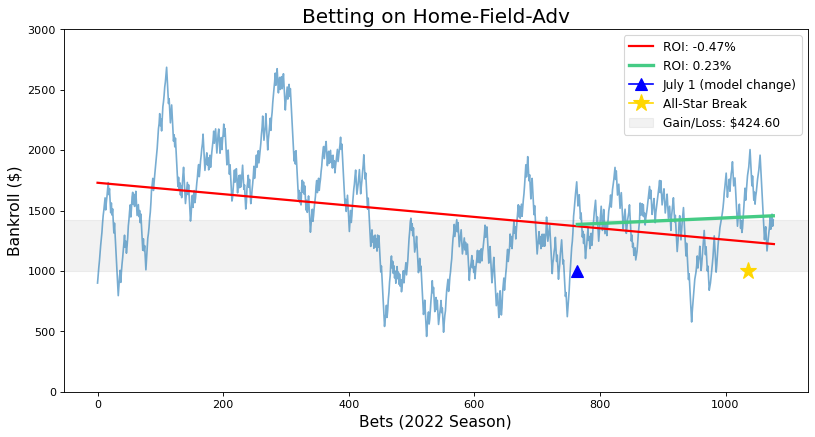

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# read in the Google Sheets - Bets .csv and clean it up
bets = pd.read_csv("/Users/chasecrawford/PycharmProjects/Real Games/07 July 2022/MLB prediction - '538' power ranking - Bets.csv", header=5)
bets = bets.drop(0).reset_index()
bets = bets.drop(['index','Date','predicted','bet on','money line','Unnamed: 7'], axis=1)
bets['bankroll'] = bets['bankroll'].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

# 'dif' here figures out how many rows need to be left off the end of the sheet (unpredicted games)
bank_len = [item for item in bets['bankroll'] if not(pd.isnull(item)) == True]
dif = len(bets) - len(bank_len)
print("Difference value: ", dif)

# prepare data for regression
x1 = pd.DataFrame(bets.index)[:-dif]
y1 = bets[['bankroll']][:-dif]

# prepare data for post-July regression
x2 = pd.DataFrame(bets.index)[765:-dif]
y2 = bets[['bankroll']][765:-dif]

# print current bankroll
latest_bankroll = bets['bankroll'].iloc[-(dif+1)]
print("Current Bankroll: ", latest_bankroll)

# print the size of DataFrame 1, to ensure ML compatability
bets_length1 = x1.shape[0]
print("DataFrame 1 Shape: ", bets.shape)
print("X1: ", x1.shape)
print("y1: ", y1.shape)

# print the size of DataFrame 2, to ensure ML compatability
bets_length2 = x2.shape[0]
print("X2: ", x2.shape)
print("y2: ", y2.shape)

# set plot size
plt.figure(figsize=(12, 6), dpi=80)

# plot empirical data
plt.plot(bets['bankroll'], alpha=0.6)

# perform LinearRegression 1
# find elements of y=mx+b for graphing purposes
lr = LinearRegression()
lr.fit(x1, y1)
m = float(lr.coef_)
b = float(lr.intercept_)
#b = 1000
print("Slope 1:     ",m,"\nIntercept 1: ", float(lr.intercept_))
x = np.linspace(0, bets_length1, 1000)
y = m*x + b
plt.plot(x, y, 
         '-r', # red color and line-type
         label="ROI: {:.2f}%".format(m), 
         linewidth=2
        )

# perform LinearRegression 2
# find elements of y=mx+b for graphing purposes
lr2 = LinearRegression()
lr2.fit(x2, y2)
m2 = float(lr2.coef_)
b = float(lr2.intercept_)
print("Slope 2:     ",m2,"\nIntercept 2: ", float(lr2.intercept_))
x = np.linspace(0, bets_length2, 1000) + 764
y3 = m2*x + b
plt.plot(x, y3, 
         '#45CB85', # green color 
         label="ROI: {:.2f}%".format(m2), 
         linewidth=3
        )

# graph settings
plt.title("Betting on Home-Field-Adv", fontsize=18)
plt.xlabel("Bets (2022 Season)", fontsize=14)
plt.xticks()
plt.ylabel("Bankroll (\$)", fontsize=14)
plt.axhspan(1000, latest_bankroll, 
            0, len(bets), 
            color="grey", alpha=0.1, 
            label="Gain/Loss: \${:.2f}".format(latest_bankroll-1000)
           )
plt.plot(764, 1000, 
         label='July 1 (model change)', 
         marker='^', markersize=10, 
         color='b'
        )
plt.plot(1036, 1000, 
         label='All-Star Break', 
         marker='*', markersize=16, 
         color='gold'
        )
plt.legend(fontsize=11)
plt.ylim(0,3000)
plt.show()

In [40]:
bets

,winner,bankroll,gain-loss
0,0.0,900.00,-$100.00
1,1.0,968.97,$68.97
2,1.0,1028.14,$59.17
3,1.0,1081.05,$52.91
4,1.0,1151.97,$70.92
...,...,...,...
1025,1.0,1418.73,$65.79
1026,0.0,1318.73,-$100.00
1027,1.0,1351.73,$33.00
1028,NaN,NaN,NaN
